In [1]:
import tensorrt
import pandas as pd
import tensorflow as tf
import numpy as np
import argparse
import importlib  
from keras.optimizers import Adam
import os
import time
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib
from utils.keras_functions import sparse_crossentropy_ignoring_last_label, Jaccard
import Keras_segmentation_deeplab_v3_1.utils
from tensorflow.python.compiler.tensorrt import trt_convert as trt


keras_deeplab = importlib.import_module("keras-deeplab-v3-plus.model")

image_size = (375,513)

losses = sparse_crossentropy_ignoring_last_label
metrics = {'pred_mask' : [Jaccard]}


def build_model(model_name, os, alpha, norm):
    try:
        deeplab_model = keras_deeplab.Deeplabv3(backbone=model_name, input_shape=(375, 513, 3), classes=19, weights='cityscapes', OS=os, alpha=alpha, infer=True, normalization=norm)
    except:
        raise Exception("No model with given backbone: ", model_name)

    deeplab_model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6), sample_weight_mode = "temporal",
              loss = losses, metrics = metrics)
    return deeplab_model

def load_model(path, load_directly, model_name):
    if not load_directly:
        deeplab_model = build_model(model_name, 8, 1, 1)
        deeplab_model.load_weights(path)
    else:
        deeplab_model = tf.keras.models.load_model(path)
    
    return deeplab_model

Version 2.x.x


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11554081820445821180
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7774339072
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5972796753499052703
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:06:00.0, compute capability: 8.6"
]


In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

#model = load_model('/mnt/7BCDA59C6DEFFE3C/kitti_weights/xception_retrained_375_0001_rndcrop_infinite/xception_retrained_375_0001_rndcrop_infinite_model.21-0.27-0.53.h5', False)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


In [5]:
model.summary()

Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 513, 375, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 513, 375, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 257, 188, 32) 864         lambda[0][0]                     
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 257, 188, 32) 128         entry_flow_conv1_1[0][0]         
______________________________________________________________________________________

In [4]:
SegClass = Keras_segmentation_deeplab_v3_1.utils.SegModel("../kitti360_dataset_truncated.csv", image_size=image_size)

test_generator = SegClass.create_generators(dataset = "../kitti360_dataset_truncated.csv", blur=0, mode='test',
                                                n_classes=19, horizontal_flip=False, vertical_flip=False, 
                                                brightness=0, rotation=False, zoom=0, batch_size=1,
                                                seed=7, do_ahisteq=False, resize_shape=(375,513))

In [5]:
options = tf.profiler.experimental.ProfilerOptions(host_tracer_level = 3,
                                            python_tracer_level = 1,
                                            device_tracer_level = 1)

In [5]:
x,y = test_generator.__getitem__(0)

In [9]:
x.shape

(1, 375, 513, 3)

In [64]:
#tf.profiler.experimental.start('logdir_profiler/keras', options)
t0 = time.time()
y_keras = model.predict(x)
t1 = time.time()
#tf.profiler.experimental.stop()
print('Keras time', t1 - t0)

Keras time 0.09475135803222656


(4, 375, 513)
[[8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 ...
 [8 8 8 ... 1 1 1]
 [8 8 8 ... 1 1 1]
 [8 8 8 ... 1 1 1]]
(192375, 1)
[[8 8 8 ... 2 2 2]
 [8 8 8 ... 2 2 2]
 [8 8 8 ... 2 2 2]
 ...
 [8 8 8 ... 1 1 1]
 [8 8 8 ... 1 1 1]
 [8 8 8 ... 1 1 1]]


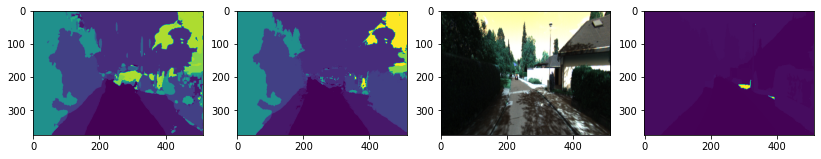

In [65]:
import numpy as np
import matplotlib.pyplot as plt

res = np.argmax(y_keras, -1)
print(res.shape)
print(res[0])

plt.figure(figsize=(14,10))
plt.subplot(141)
plt.imshow(res[0].astype('uint8'))
MAP = Keras_segmentation_deeplab_v3_1.utils.do_crf(x[0], res[0], zero_unsure=False)
plt.subplot(142)
plt.imshow(MAP.astype('uint8'))
plt.subplot(143)
plt.imshow(x[0].astype('int32'))
plt.subplot(144)
plt.imshow(y[0].reshape(image_size).astype('uint8'))
print(y[0].shape)
print(y[0].reshape(image_size))

In [12]:
model.save('pb_files/xception_freezed_513_375/')

INFO:tensorflow:Assets written to: pb_files/xception_freezed_513_375/assets


In [13]:
print('Converting to TF-TRT FP16...')
conversion_params = tf.experimental.tensorrt.ConversionParams(precision_mode='FP16', max_workspace_size_bytes=(4<<25))

converter = trt.TrtGraphConverterV2(input_saved_model_dir='pb_files/xception_freezed_513_375/', conversion_params=conversion_params)
converter.convert()

Converting to TF-TRT FP16...
INFO:tensorflow:Linked TensorRT version: (7, 2, 2)
INFO:tensorflow:Loaded TensorRT version: (7, 2, 3)
INFO:tensorflow:Loaded TensorRT 7.2.3 and linked TensorFlow against TensorRT 7.2.2. This is supported because TensorRT  minor/patch upgrades are backward compatible


<ConcreteFunction pruned(input_1) at 0x7F3A0867ED30>

In [14]:
def in_func():
    input_sizes = [[513, 375]]
    for size in input_sizes:
        inp1 = np.random.normal(size=(1, *size, 3)).astype(np.float32)
        yield [inp1]

converter.build(input_fn=in_func)

In [15]:
converter.save(output_saved_model_dir='converted_trt/xception_freezed_513_375_16bit')
print('Done Converting to TF-TRT FP16')

INFO:tensorflow:Assets written to: converted_trt/xception_freezed_513_375_16bit/assets
Done Converting to TF-TRT FP16


In [9]:
from tensorflow.python.saved_model import tag_constants

"""Runs prediction on a single image and shows the result.
input_saved_model (string): Name of the input model stored in the current dir
"""

inp = tf.constant(x)

saved_model_loaded = tf.saved_model.load('converted_trt/xception_freezed_FP16_1batch/', tags=[tag_constants.SERVING])
signature_keys = list(saved_model_loaded.signatures.keys())
print(signature_keys)

infer = saved_model_loaded.signatures['serving_default']
print(infer.structured_outputs)

['serving_default']
{'lambda_5': TensorSpec(shape=<unknown>, dtype=tf.float32, name='lambda_5')}


In [13]:
#tf.profiler.experimental.start('logdir_profiler/tensorrt_FP16_2', options)
t0 = time.time()
labeling = infer(inp)
t1 = time.time()
#tf.profiler.experimental.stop()
print('TensorRT time', t1 - t0)
print(labeling)

TensorRT time 0.014468908309936523
{'lambda_5': <tf.Tensor: shape=(1, 375, 513, 19), dtype=float32, numpy=
array([[[[ -64.77344 ,  -64.386475,  -62.81836 , ...,  -64.793945,
           -64.11133 ,  -64.56836 ],
         [ -67.11719 ,  -66.730225,  -65.00586 , ...,  -67.09082 ,
           -66.39258 ,  -66.88867 ],
         [ -69.46094 ,  -69.073975,  -67.19336 , ...,  -69.387695,
           -68.67383 ,  -69.208984],
         ...,
         [ -94.11719 ,  -93.355225,  -91.78711 , ...,  -93.231445,
           -93.17383 ,  -93.84961 ],
         [ -93.75781 ,  -92.9646  ,  -91.490234, ...,  -92.887695,
           -92.89258 ,  -93.47461 ],
         [ -93.39844 ,  -92.573975,  -91.19336 , ...,  -92.543945,
           -92.61133 ,  -93.09961 ]],

        [[ -68.87638 ,  -68.42725 ,  -66.81251 , ...,  -68.679306,
           -68.13656 ,  -68.616905],
         [ -70.35758 ,  -69.88514 ,  -68.153   , ...,  -70.15248 ,
           -69.55915 ,  -70.0805  ],
         [ -71.838776,  -71.343025,  -69.4934

In [29]:
labeling[list(labeling.keys())[0]].numpy()

array([[[[ -64.75261 ,  -64.36727 ,  -62.77    , ...,  -64.743065,
           -64.066895,  -64.5224  ],
         [ -67.12659 ,  -66.74243 ,  -65.00061 , ...,  -67.07527 ,
           -66.38266 ,  -66.88393 ],
         [ -69.50057 ,  -69.117584,  -67.23122 , ...,  -69.40748 ,
           -68.69842 ,  -69.245445],
         ...,
         [ -93.98829 ,  -93.18932 ,  -91.63475 , ...,  -93.093155,
           -92.99274 ,  -93.69087 ],
         [ -93.66338 ,  -92.844696,  -91.36386 , ...,  -92.788536,
           -92.74841 ,  -93.36013 ],
         [ -93.33848 ,  -92.50008 ,  -91.092964, ...,  -92.48392 ,
           -92.50409 ,  -93.029396]],

        [[ -68.89273 ,  -68.454414,  -66.8144  , ...,  -68.68071 ,
           -68.1464  ,  -68.61513 ],
         [ -70.40198 ,  -69.939575,  -68.19326 , ...,  -70.18297 ,
           -69.59787 ,  -70.11476 ],
         [ -71.91123 ,  -71.42473 ,  -69.57211 , ...,  -71.68522 ,
           -71.04933 ,  -71.614395],
         ...,
         [ -96.029274,  -95.24561 

(4, 375, 513)
[[8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 ...
 [8 8 8 ... 1 1 1]
 [8 8 8 ... 1 1 1]
 [8 8 8 ... 1 1 1]]
(192375, 1)
[[8 8 8 ... 2 2 2]
 [8 8 8 ... 2 2 2]
 [8 8 8 ... 2 2 2]
 ...
 [8 8 8 ... 1 1 1]
 [8 8 8 ... 1 1 1]
 [8 8 8 ... 1 1 1]]


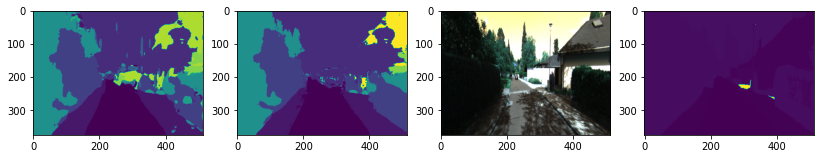

In [27]:
res = np.argmax(labeling['lambda_5'].numpy(), -1)
print(res.shape)
print(res[0])

plt.figure(figsize=(14,10))
plt.subplot(141)
plt.imshow(res[0].astype('uint8'))
MAP = Keras_segmentation_deeplab_v3_1.utils.do_crf(x[0], res[0], zero_unsure=False)
plt.subplot(142)
plt.imshow(MAP.astype('uint8'))
plt.subplot(143)
plt.imshow(x[0].astype('int32'))
plt.subplot(144)
plt.imshow(y[0].reshape(image_size).astype('uint8'))
print(y[0].shape)
print(y[0].reshape(image_size))

# Attempting NCHW ordering

In [22]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from PIL import Image

def create_cityscapes_label_colormap():
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap


def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_cityscapes_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray(['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 
               'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 
               'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle','unknown'])
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [40]:
def mIOU(gt, preds):
    ulabels = np.unique(gt)
    iou = np.zeros(len(ulabels))
    for k, u in enumerate(ulabels):
        inter = (gt == u) & (preds==u)
        union = (gt == u) | (preds==u)
        iou[k] = inter.sum()/union.sum()
    return np.round(iou.mean(), 2)

In [5]:
model = load_model('/mnt/7BCDA59C6DEFFE3C/kitti_weights/xception_retrained_375_0001_rndcrop_infinite/xception_retrained_375_0001_rndcrop_infinite_model.21-0.27-0.53.h5')

Cityscapes!


In [10]:
from tensorflow.python.saved_model import tag_constants

"""Runs prediction on a single image and shows the result.
input_saved_model (string): Name of the input model stored in the current dir
"""

saved_model_loaded = tf.saved_model.load('converted_trt/xception_freezed_FP16_1batch/', tags=[tag_constants.SERVING])
signature_keys = list(saved_model_loaded.signatures.keys())
print(signature_keys)

infer = saved_model_loaded.signatures['serving_default']
print(infer.structured_outputs)

['serving_default']
{'lambda_5': TensorSpec(shape=<unknown>, dtype=tf.float32, name='lambda_5')}


In [4]:
dataset = pd.read_csv('../kitti360_dataset.csv')
dataset = dataset[dataset['subset'] == 'test']

In [5]:
# Reading image with cv2

x_cv = cv2.imread(dataset.iloc[1000].x, 1)
x_cv = cv2.resize(x_cv, (513,375))
x_cv = np.expand_dims(x_cv, axis=0)
x_cv = x_cv.astype('float32')

x_cv.shape

(1, 375, 513, 3)

In [104]:
# Reading image with imageio
import imageio

x_io = imageio.imread(dataset.iloc[1000].x)
#x_io = cv2.resize(x_io, (513,375))
x_io = np.expand_dims(x_io, axis=0)
x_io = x_io.astype('float32')

x_io.shape

(1, 376, 1408, 3)

In [92]:
y = cv2.imread(dataset.iloc[1000].x, 0)
y = cv2.resize(y, (513,375), interpolation = cv2.INTER_NEAREST)

y.shape

(375, 513)

0.0


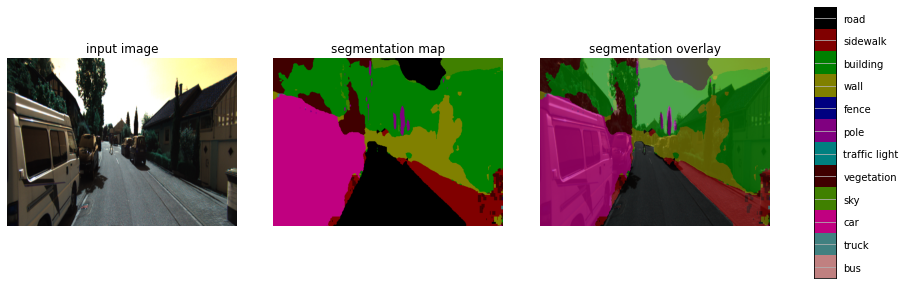

In [93]:
# Infering using CV2

## Infering on keras model
res_cv = model.predict(x_cv)
res_cv = np.argmax(res_cv.squeeze(), axis=-1)

print(mIOU(y,res_cv))
vis_segmentation(x_cv[0].astype('int32'), res_cv)

0.0


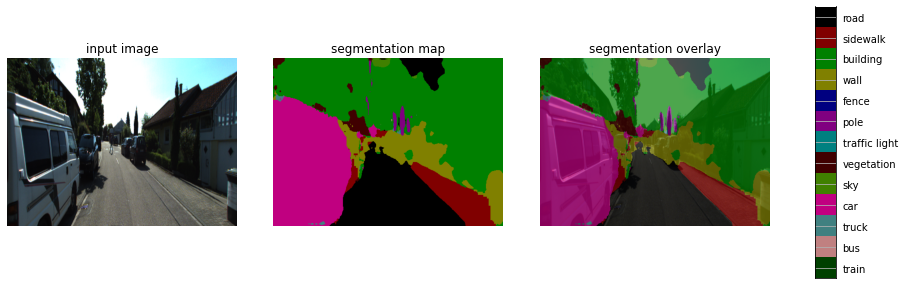

In [102]:
# Infering using imageio

## Infering on keras model
res_io = model.predict(x_io)
res_io = np.argmax(res_io.squeeze(), axis=-1)

print(mIOU(y,res_io))
vis_segmentation(x_io[0].astype('int32'), res_io)

0.0


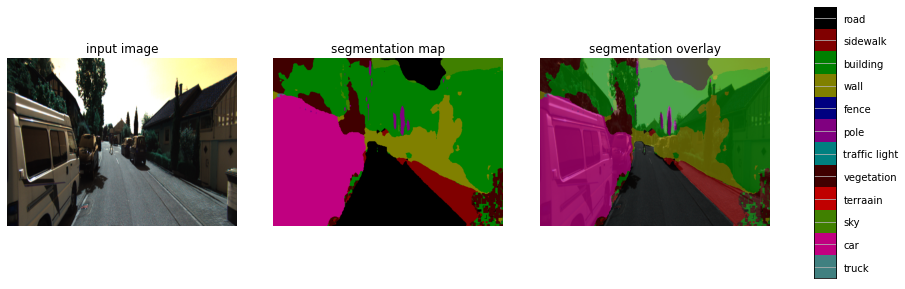

In [94]:
# Infering using CV2

## Infering on tensorRT model
inp = tf.constant(x_cv)
res_cv = infer(inp)
res_cv = np.argmax(res_cv['lambda_5'], axis=-1)

print(mIOU(y,res_cv))
vis_segmentation(x_cv[0].astype('int32'), res_cv[0].astype('uint8'))

In [72]:
x_cv_tr = np.transpose(x_cv ,(0, 3, 1, 2))

inp = tf.constant(x_cv_tr)
res_cv_tr = infer(inp)
res_cv_tr = np.argmax(res_cv_tr['lambda_5'], axis=-1)

#print(mIOU(y,res_cv_tr))
#vis_segmentation(x_cv[0].astype('int32'), res_cv_tr[0].astype('uint8'))

NotFoundError:   No algorithm worked!
	 [[node StatefulPartitionedCall/deeplabv3plus/entry_flow_conv1_1/Conv2D (defined at <ipython-input-7-7f4952a4840e>:7) ]]
	 [[PartitionedCall/TRTEngineOp_0_0]] [Op:__inference_signature_wrapper_55949]

Function call stack:
signature_wrapper -> TRTEngineOp_0_0_native_segment


0.0


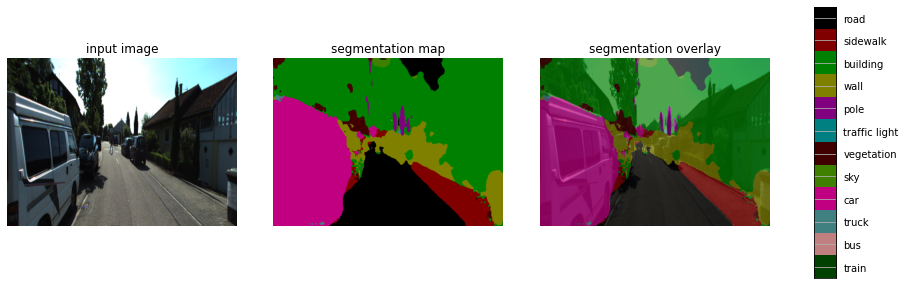

In [100]:
# Infering using imageio

## Infering on tensorRT model
inp = tf.constant(x_io)
res_io = infer(inp)
res_io = np.argmax(res_io['lambda_5'], axis=-1)

print(mIOU(y,res_io))
vis_segmentation(x_io[0].astype('int32'), res_io[0])

In [106]:
np.testing.assert_array_equal(x_cv,x_io)

AssertionError: 
Arrays are not equal

Mismatched elements: 923188 / 1588224 (58.1%)
Max absolute difference: 233.
Max relative difference: 154.
 x: array([[[[ 18.,  19.,  17.],
         [ 20.,  21.,  19.],
         [ 19.,  22.,  24.],...
 y: Array([[[[ 17.,  19.,  18.],
         [ 19.,  21.,  20.],
         [ 24.,  22.,  19.],...

## Time comparisson

In [6]:
#model = load_model('/mnt/7BCDA59C6DEFFE3C/kitti_weights/xception_retrained_375_0001_rndcrop_infinite/xception_retrained_375_0001_rndcrop_infinite_model.21-0.27-0.53.h5', False)
model = build_model('xception', 8, 1, 1)

Cityscapes!


In [8]:
model.summary()

Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 375, 513, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 375, 513, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 188, 257, 32) 864         lambda[0][0]                     
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 188, 257, 32) 128         entry_flow_conv1_1[0][0]         
______________________________________________________________________________________

In [7]:
# Keras Model

for l in range(2):
    times = []
    for i in range(10):
        start = time.time()
        res_cv = model.predict(x_cv)
        res_cv = np.argmax(res_cv.squeeze(), axis=-1)
        end = time.time()
        times.append(end-start)
    print(l, '. Keras mean time: ', np.mean(times))
print(tf.config.experimental.get_memory_info('GPU:0')['current'] / 1024  / 1024)
print(tf.config.experimental.get_memory_info('GPU:0')['peak'] / 1024  / 1024)

0 . Keras mean time:  0.30569050312042234
1 . Keras mean time:  0.053563499450683595
174.28515625
889.2099609375


In [6]:
from tensorflow.python.saved_model import tag_constants

"""Runs prediction on a single image and shows the result.
input_saved_model (string): Name of the input model stored in the current dir
"""
saved_model_loaded = tf.saved_model.load('converted_trt/xception_freezed_FP16_1batch/', tags=[tag_constants.SERVING])
signature_keys = list(saved_model_loaded.signatures.keys())
print(signature_keys)

infer = saved_model_loaded.signatures['serving_default']
print(infer.structured_outputs)

['serving_default']
{'lambda_5': TensorSpec(shape=<unknown>, dtype=tf.float32, name='lambda_5')}


In [7]:
# TensorRT Model

for l in range(2):
    times = []
    for i in range(10):
        start = time.time()
        inp = tf.constant(x_cv)
        res_cv = infer(inp)
        res_cv = np.argmax(res_cv['lambda_5'], axis=-1)
        end = time.time()
        times.append(end-start)
    print(l, '. TensorRT mean time: ', np.mean(times))
print(tf.config.experimental.get_memory_info('GPU:0')['current'] / 1024  / 1024)
print(tf.config.experimental.get_memory_info('GPU:0')['peak'] / 1024  / 1024)

0 . TensorRT mean time:  0.13632850646972655
1 . TensorRT mean time:  0.017832064628601076
272.661376953125
566.460693359375


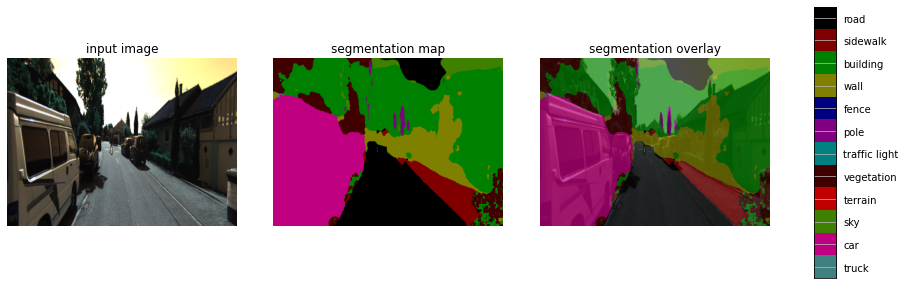

In [23]:
vis_segmentation(x_cv[0].astype('uint32'),res_cv[0])

In [6]:
model = load_model('../pruned_models/all_layers_pruning.h5', False, 'xception')

Cityscapes!
166100992/166094648 [==============================] - 7s 0us/step


In [8]:
model.summary()

Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 375, 513, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 375, 513, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 188, 257, 32) 864         lambda[0][0]                     
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 188, 257, 32) 128         entry_flow_conv1_1[0][0]         
______________________________________________________________________________________

In [8]:
# Pruned Model
for l in range(2):
    times = []
    for i in range(10):
        start = time.time()
        res_cv = model.predict(x_cv)
        res_cv = np.argmax(res_cv.squeeze(), axis=-1)
        end = time.time()
        times.append(end-start)
    print(l, '. Keras mean time: ', np.mean(times))
print(tf.config.experimental.get_memory_info('GPU:0')['current'] / 1024  / 1024)
print(tf.config.experimental.get_memory_info('GPU:0')['peak'] / 1024  / 1024)

0 . Keras mean time:  0.4807556629180908
1 . Keras mean time:  0.05083451271057129
168.97607421875
885.490478515625


# Example results

In [88]:
dataset = pd.read_csv('../kitti360_dataset.csv')
dataset = dataset[dataset['subset'] == 'test']

(1, 375, 513, 3)


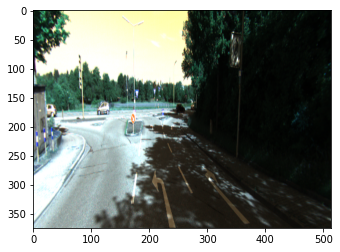

In [127]:
# Reading image with cv2

x_cv = cv2.imread(dataset.iloc[820].x)
x_cv = cv2.resize(x_cv, (513,375))
x_cv = np.expand_dims(x_cv, axis=0)
x_cv = x_cv.astype('float32')

print(x_cv.shape)
plt.imshow(x_cv[0].astype('uint32'))

Cityscapes!


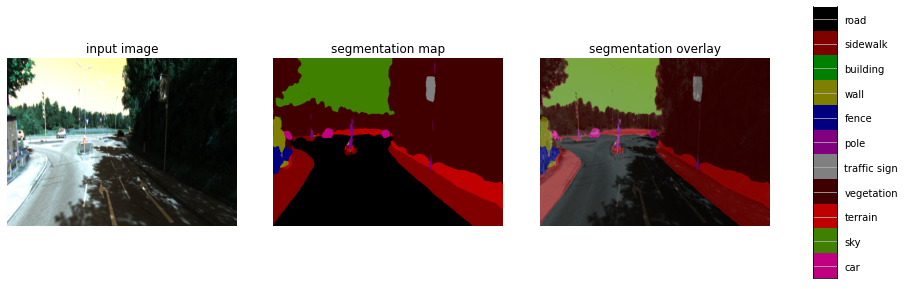

In [128]:
model = load_model('/mnt/7BCDA59C6DEFFE3C/kitti_weights/xception_retrained_375_0001_rndcrop_infinite/xception_retrained_375_0001_rndcrop_infinite_model.21-0.27-0.53.h5', False, 'xception')

res_cv = np.argmax(model.predict(x_cv).squeeze(), axis=-1)
vis_segmentation(x_cv.astype('uint32')[0], res_cv)

['serving_default']
{'lambda_5': TensorSpec(shape=<unknown>, dtype=tf.float32, name='lambda_5')}


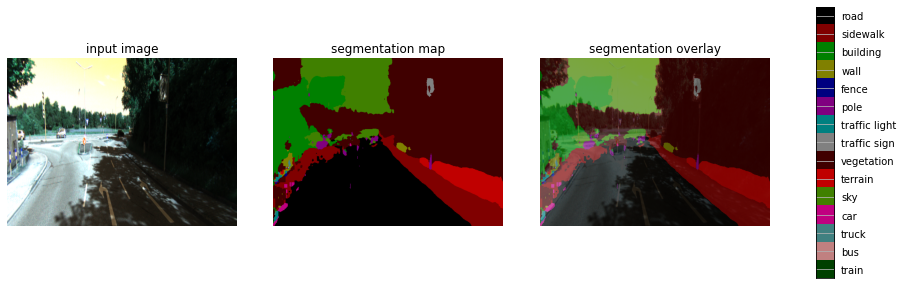

In [129]:
#saved_model_loaded = tf.saved_model.load('converted_trt/xception_freezed_FP16_1batch/', tags=[tag_constants.SERVING])
signature_keys = list(saved_model_loaded.signatures.keys())
print(signature_keys)

infer = saved_model_loaded.signatures['serving_default']
print(infer.structured_outputs)

inp = tf.constant(x_cv)
res_cv = np.argmax(infer(inp)['lambda_5'], axis=-1)
vis_segmentation(x_cv.astype('uint32')[0], res_cv[0])

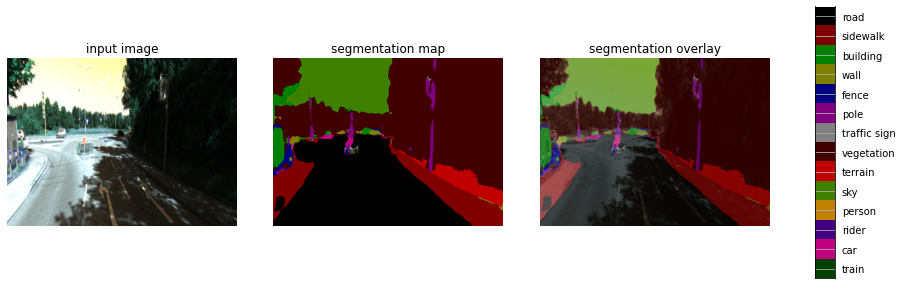

In [130]:
model = load_model('../pruned_models/all_layers_pruning.h5', True, 'xception')

res_cv = np.argmax(model.predict(x_cv).squeeze(), axis=-1)
res_cv = np.reshape(res_cv, (375,513))
vis_segmentation(x_cv.astype('uint32')[0], res_cv)

Cityscapes!


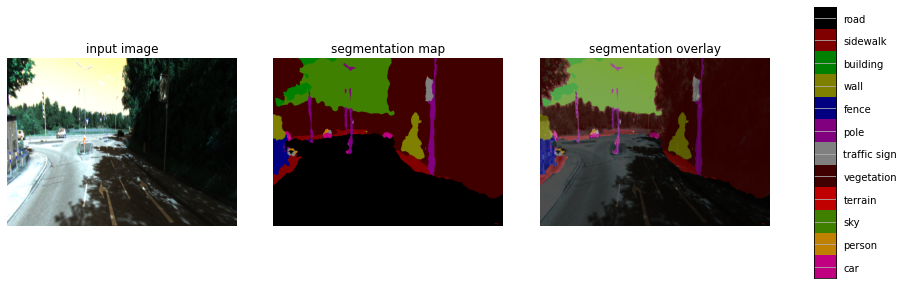

In [131]:
model = build_model('xception', 8, 1, 1)

res_cv = np.argmax(model.predict(x_cv).squeeze(), axis=-1)
res_cv = np.reshape(res_cv, (375,513))
vis_segmentation(x_cv.astype('uint32')[0], res_cv)

Cityscapes!


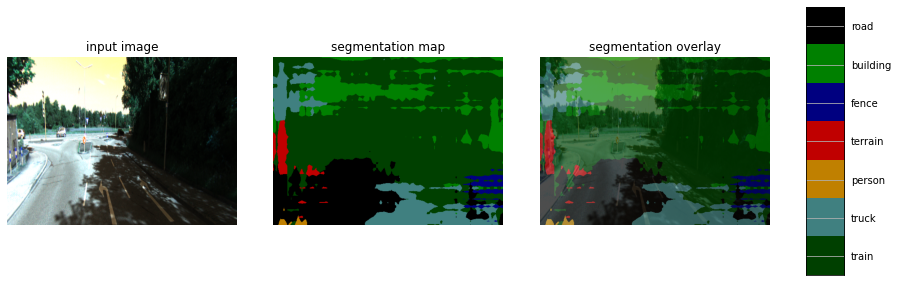

In [132]:
model = build_model('mobilenetv2', 8, 1, 1)

res_cv = np.argmax(model.predict(x_cv).squeeze(), axis=-1)
res_cv = np.reshape(res_cv, (375,513))
vis_segmentation(x_cv.astype('uint32')[0], res_cv)

Cityscapes!


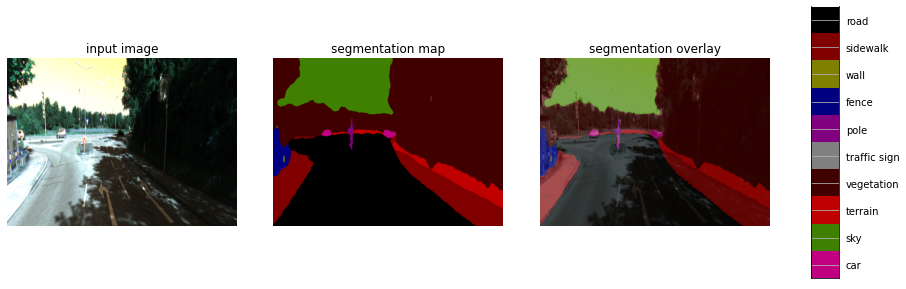

In [133]:
model = load_model('/mnt/7BCDA59C6DEFFE3C/kitti_weights/mobilenetv2_retrained__375_00001lr_rndcrop_infinite/mobilenetv2_retrained__375_00001lr_rndcrop_infinite_model.08-0.29-0.49.h5', False, 'mobilenetv2')

res_cv = np.argmax(model.predict(x_cv).squeeze(), axis=-1)
vis_segmentation(x_cv.astype('uint32')[0], res_cv)

In [6]:
model = build_model('mobilenetv2', 8, 1, 1)
model.summary()

Cityscapes!
8986624/8984520 [==============================] - 2s 0us/step
Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 375, 513, 3) 0                                            
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 188, 257, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv_BN (BatchNormalization)    (None, 188, 257, 32) 128         Conv[0][0]                       
__________________________________________________________________________________________________
Conv_Relu6 (Activation)         (None, 188, 257, 32) 0           Conv_BN[0][0]                    
___________

expanded_conv_14_depthwise (Dep (None, 47, 65, 960)  8640        expanded_conv_14_expand_relu[0][0
__________________________________________________________________________________________________
expanded_conv_14_depthwise_BN ( (None, 47, 65, 960)  3840        expanded_conv_14_depthwise[0][0] 
__________________________________________________________________________________________________
expanded_conv_14_depthwise_relu (None, 47, 65, 960)  0           expanded_conv_14_depthwise_BN[0][
__________________________________________________________________________________________________
expanded_conv_14_project (Conv2 (None, 47, 65, 160)  153600      expanded_conv_14_depthwise_relu[0
__________________________________________________________________________________________________
expanded_conv_14_project_BN (Ba (None, 47, 65, 160)  640         expanded_conv_14_project[0][0]   
__________________________________________________________________________________________________
expanded_c

In [12]:
for l in range(2):
    times = []
    for i in range(10):
        start = time.time()
        res_cv = model.predict(x_cv)
        res_cv = np.argmax(res_cv.squeeze(), axis=-1)
        end = time.time()
        times.append(end-start)
    print(l, '. Keras mean time: ', np.mean(times))
print(tf.config.experimental.get_memory_info('GPU:0')['current'] / 1024  / 1024)
print(tf.config.experimental.get_memory_info('GPU:0')['peak'] / 1024  / 1024)

0 . Keras mean time:  0.029277825355529787
1 . Keras mean time:  0.027359700202941893
9.361083984375
178.865234375
